In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
sys.path.append("..")
from src.dataset import SIModel
from src.approx_bc import abc_rejection_sampler
import seaborn as sns
from scipy.stats import norm, lognorm, multivariate_normal

In [16]:
sns.set_theme()
sns.set_style("white")

run_abc = True

beta_true = [0.05, .1, .2, .3, .4, .5, 5]
alpha = 0.1
gamma = 0.05
heterogeneous = True
N = 300 # consider increasing
T = 52
K = 30
data_seed = 31
prior_mu = [-3, -1.5, -1.5, -1.5, -1.5, -1.5, 1]
prior_sigma = [1, 1, 1, 1, 1, 1, 1]

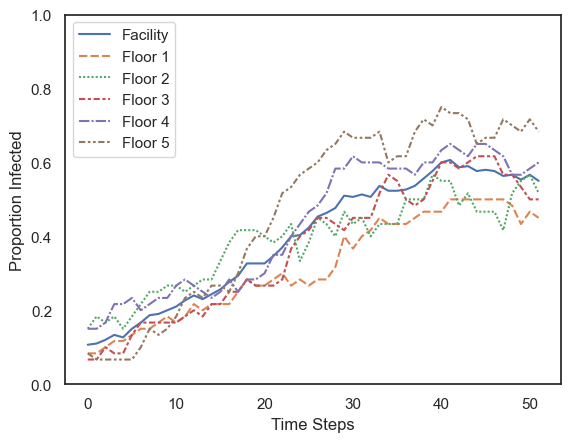

In [3]:
si_model = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, flatten=False,
                  observed_seed=data_seed)
x_o = si_model.get_observed_data()

data = x_o[:6,:]

data = pd.DataFrame(data = data.T, columns=["Facility"] + [f"Floor {i}" for i in range(1,6)])

sns.lineplot(data)
plt.ylim((0,1))
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
plt.savefig("images/hetero_infection_viz.png")
plt.show()

In [4]:
# prior = norm(prior_mu, prior_sigma)
# prior_sample = np.exp(prior.rvs(size=(K, 7), random_state=2))
# prior_predictive = np.empty((K, 7 ,T))

# for i in range(K):
#     si_model = SIModel(alpha, gamma, prior_sample[i], 
#                     heterogeneous, prior_mu, prior_sigma,
#                    N, T, summarize=False, flatten=False,
#                   observed_seed=None)
#     x_rep = si_model.get_observed_data(i)
#     prior_predictive[i] =  np.array(x_rep)
# prp_mean = prior_predictive.mean(0)[0]

# labels = ["Prior Pred. Draw"] + [None for _ in range(K-1)]
# I_o = np.array(x_o)[0]
# plt.plot(I_o, label="Observed", color="k")
# plt.plot(prior_predictive[:,0,:].T, 
#          label=labels, color="b",
#          alpha=0.2)
# plt.plot(prp_mean, label="Prior Pred. Mean", linestyle="--",
#          color="orange")
# plt.legend()
# plt.title("Prior Predictive Check of Total Infected")
# plt.ylabel("Proportion Infected")
# plt.xlabel("Time Steps")
# plt.show()

# Likelihood-based

In [5]:
exact_means = [-2.89, -2.52, -1.47, -1.88, -1.27, -0.72, 1.59]
exact_rates = [0.057, 0.096, 0.25, 0.18, 0.30, 0.50, 5.2]
exact_sds = [0.27, 0.62, 0.39, 0.55, 0.35, 0.23, 0.37]

# NPE

In [7]:
df_npe = pd.read_csv("npe_het.csv")
df_npe["mu"] = df_npe["mu"].apply(lambda x: eval(x)[0])
df_npe["sigma"] = df_npe["sigma"].apply(lambda x: eval(x))

In [116]:
r = df_npe.loc[4]
npe_rates = []
npe_means = []
npe_sds = []
for j in range(7):
    # print(beta_true[j])
    m = r["mu"][j]
    npe_means.append(m)
    s = r["sigma"][j][j]
    npe_sds.append(s**.5)
    npe_rates.append(np.exp(m + s/2))
    # print(np.exp(m + s/2))
    # # print(m)
    # # print(np.sqrt(s))
    # print("****")

## Posterior Predictive Checks

In [8]:
mu = np.array(df_npe.loc[4]["mu"])
sigma = np.array(df_npe.loc[4]["sigma"])

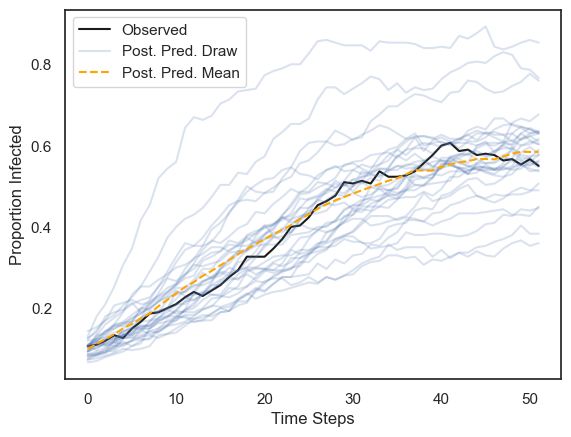

In [10]:
neural_posterior = multivariate_normal(mu, sigma)
K = 30
npe_sample = np.exp(neural_posterior.rvs(size=K, random_state=2))
posterior_predictive = np.empty((K, 7, T))

si_model = SIModel(alpha, gamma, beta_true, 
                   heterogeneous, prior_mu, prior_sigma, 
                   N, T, summarize=False, observed_seed=31,
                   flatten=False)
x_o = si_model.get_observed_data()

for i in range(K):
    si_model = SIModel(alpha, gamma, npe_sample[i], 
                   heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, observed_seed=31, flatten=False)
                   # pi = [.2, 1, 1, 1, 1, 1, 1])
    x_rep = si_model.get_observed_data(i)
    posterior_predictive[i] =  np.array(x_rep)
pp_mean = posterior_predictive.mean(0)[0]

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive[:,0,:].T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
# plt.title("NPE Posterior Predictive Check")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.savefig("images/ppc_het.png")
plt.show()

In [ ]:
# floor_ppc = pd.DataFrame(data = posterior_predictive.mean(0)[:6].T, 
#              columns=["Facility"] + [f"Floor {i}" for i in range(1,6)])

# sns.lineplot(floor_ppc)
# plt.legend()
# plt.ylim(0,1)
# plt.xlabel("Time Steps")
# plt.ylabel("Proportion Infected")
# plt.show()

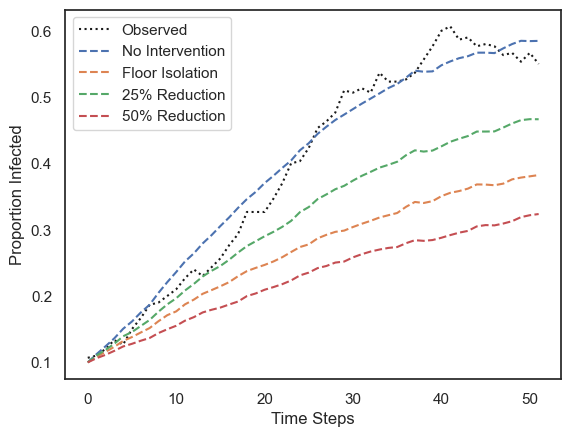

In [14]:
pis = [
    [.1, 1, 1, 1, 1, 1, 1],
    [.75, .75, .75, .75, .75, .75, .75],
    [.5, .5, .5, .5, .5, .5, .5],
    [.25, .25, .25, .25, .25, .25, .25]
]
intervention = np.empty((K, len(pis), T))
for j, pi in enumerate(pis):
    for i in range(K):
        si_model = SIModel(alpha, gamma, npe_sample[i], 
                    heterogeneous, prior_mu, prior_sigma,
                    N, T, summarize=False, observed_seed=31, flatten=False,
                    pi=pi)
        x_rep = si_model.get_observed_data(i)
        intervention[i,j] =  np.array(x_rep)[0]
sds = intervention.std(0)
intervention = intervention.mean(0)

plt.plot(I_o, label="Observed", color="k", linestyle=":")
plt.plot(pp_mean, label="No Intervention", linestyle="--")
plt.plot(intervention[0], label="Floor Isolation", linestyle="--")
plt.plot(intervention[1], label="25% Reduction", linestyle="--")
plt.plot(intervention[2], label="50% Reduction", linestyle="--")
# plt.plot(intervention[3], label="75% Reduction", linestyle="--")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
plt.savefig("images/intervention.png")
# plt.title("Interventions in Heterogeneous Transmission")
plt.show()

## ABC

In [17]:
if run_abc:
    abc_data = {"summarize":[], "epsilon":[], "simulations":[]}
    abc_samples = []
    
    args = [(False, [2.5, 2.3, 2.1, 1.9, 1.7]),
            (True, [0.3, 0.275, 0.25, 0.2, .15])]
    for summarize, es in args:
        for epsilon in es:
            si_model = SIModel(alpha, gamma, beta_true, 
                            heterogeneous, prior_mu, prior_sigma, 
                           N, T, summarize, observed_seed=31, flatten=False)
            prior_sampler = lambda: si_model.sample_logbeta(1)
            simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
            x_o = si_model.get_observed_data()
            S = 100
            print(f"epsilon: {epsilon}")
            posterior_sample, errors = abc_rejection_sampler(
                S, epsilon, prior_sampler, simulator, x_o, max_attempts=40000,
                summarize=summarize
                )
            print("***")
            abc_data["summarize"].append(summarize)
            abc_data["epsilon"].append(epsilon)
            abc_data["simulations"].append((errors > 0).sum())
            abc_samples.append(posterior_sample)   

epsilon: 2.5
Time lapsed: 8.92 seconds
With tolerance 2.5, acceptance rate: 0.182482
Total number of attempts: 548
***
epsilon: 2.3
Time lapsed: 10.87 seconds
With tolerance 2.3, acceptance rate: 0.150602
Total number of attempts: 664
***
epsilon: 2.1
Time lapsed: 21.09 seconds
With tolerance 2.1, acceptance rate: 0.077160
Total number of attempts: 1,296
***
epsilon: 1.9
Time lapsed: 42.28 seconds
With tolerance 1.9, acceptance rate: 0.038655
Total number of attempts: 2,587
***
epsilon: 1.7
Attempts: 5,000
Time lapsed: 102.87 seconds
With tolerance 1.7, acceptance rate: 0.015855
Total number of attempts: 6,307
***
epsilon: 0.3
Time lapsed: 6.65 seconds
With tolerance 0.3, acceptance rate: 0.246305
Total number of attempts: 406
***
epsilon: 0.275
Time lapsed: 8.84 seconds
With tolerance 0.275, acceptance rate: 0.185529
Total number of attempts: 539
***
epsilon: 0.25
Time lapsed: 11.29 seconds
With tolerance 0.25, acceptance rate: 0.145138
Total number of attempts: 689
***
epsilon: 0.2
T

In [18]:
df_abc = pd.DataFrame(abc_data)
abc_posterior = np.array(abc_samples)
# df_abc = df_abc.join(pd.DataFrame(data = np.exp(abc_posterior).mean(1)))
df_abc = df_abc.join(pd.DataFrame(data = abc_posterior.mean(1)))
df_abc = df_abc.melt(id_vars=["summarize", "epsilon", "simulations"], var_name="Beta", value_name="mean")
df_abc["Method"] = df_abc["summarize"].apply(lambda x: "ABC-S" if x else "ABC")

df_abc2 = pd.DataFrame(abc_data).join(pd.DataFrame(data = abc_posterior.std(1)))
df_abc2 = df_abc2.melt(id_vars=["summarize", "epsilon", "simulations"], var_name="Beta", value_name="sd")
df_abc["sd"] = df_abc2["sd"]

df_abc["posterior mean"] = np.exp(df_abc["mean"] + df_abc["sd"]**2 / 2)

In [20]:
df_abc.to_csv("abc_het.csv")

In [15]:
# shoot i forgot to save it

In [ ]:
# abc_rates = df_abc[df_abc["summarize"] == False].sort_values(["simulations", "Beta"]).tail(7)["posterior mean"].values

# abc_s_rates = df_abc[df_abc["summarize"] == True].sort_values(["simulations", "Beta"]).tail(7)["posterior mean"].values

### comparison

In [73]:
npe_rates

[0.05688689705905119,
 0.14007662127538542,
 0.2265113728873097,
 0.24277779224726304,
 0.3608829275840042,
 0.4729986451392747,
 5.037826360703589]

In [40]:
df_abc[df_abc["summarize"] == False].sort_values(["simulations", "Beta"]).tail(7)["sd"].values

array([0.32233283, 0.669429  , 0.73412365, 0.70689183, 0.6232474 ,
       0.66502887, 0.9540188 ], dtype=float32)

In [38]:
df_abc[df_abc["summarize"] == True].sort_values(["simulations", "Beta"]).tail(7)["posterior mean"].values

array([0.06905773, 0.15493812, 0.23420319, 0.19971597, 0.27624425,
       0.34944004, 3.6450753 ], dtype=float32)

In [78]:
abc_rates - np.array(exact_rates)

array([ 0.00926762,  0.05411205, -0.06275068,  0.00848512, -0.01813381,
       -0.11005241, -1.33201451])

### Visualization

In [47]:
def het_plotter(j, mode="mean", savename=None):
    m = np.array([r["mu"][j] for _, r in df_npe.iterrows()])
    s = np.array([r["sigma"][j][j] for _, r in df_npe.iterrows()])
    df_viz = pd.DataFrame({
    "Method": ["NPE" for _ in range(len(df_npe))],
    "simulations": df_npe["n_sample"],
    "mean": m,
    "sd": np.sqrt(s),
    "posterior mean": np.exp(m + s/2)
    })
    df_viz = pd.concat([df_viz, df_abc[df_abc["Beta"] == j][["Method", "simulations", "mean", "sd", "posterior mean"]]])
    ax = sns.lineplot(df_viz, x="simulations", y=mode, hue="Method", marker="o")
    if mode == "mean":
        ax.axhline(y = exact_means[j], color="k", linestyle="--", label="Exact Mean")
        plt.ylabel("Posterior Mean")
    elif mode == "posterior mean":
        ax.axhline(y = exact_rates[j], color="k", linestyle="--", label="Exact Rate")
        plt.ylabel("Posterior Mean")
    elif mode == "sd":
        ax.axhline(y = exact_sds[j], color="k", linestyle="--", label="Exact SD")
        plt.ylabel("Posterior Standard Deviation")
        plt.ylim(0, None)
    plt.xscale("log")
    plt.xlabel("Simulations")
    plt.legend(title=None)
    # plt.title(rf"Simulation-based Inference of $\beta_{j}$")
    ax.set_xticks([500, 1000, 2000, 4000])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    if savename is not None:
        plt.savefig(savename)
    plt.show()


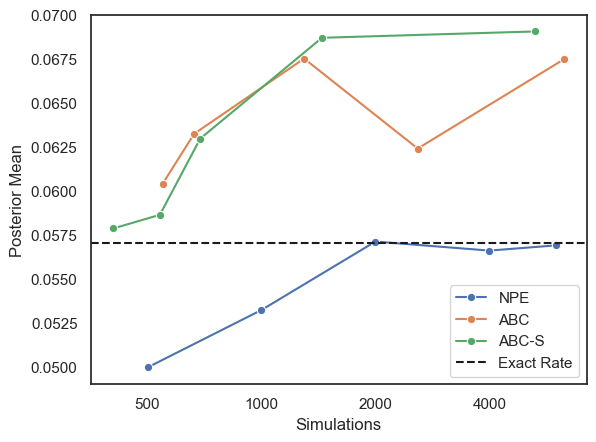

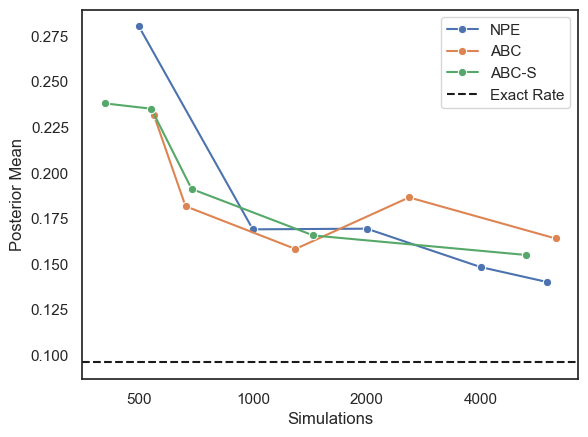

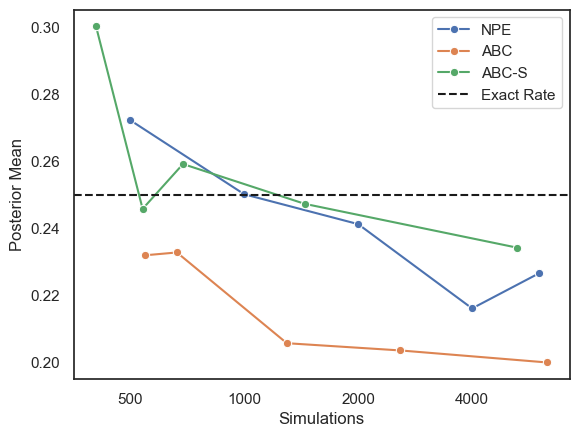

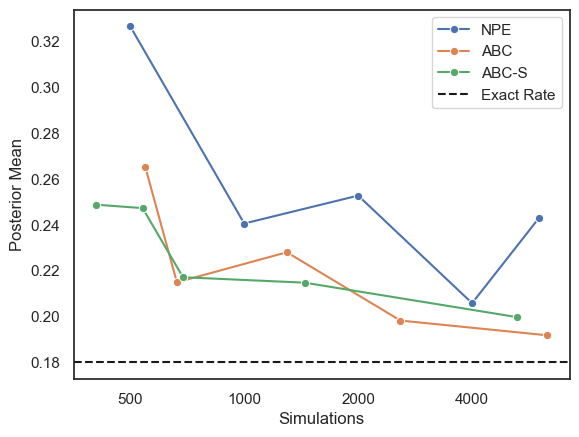

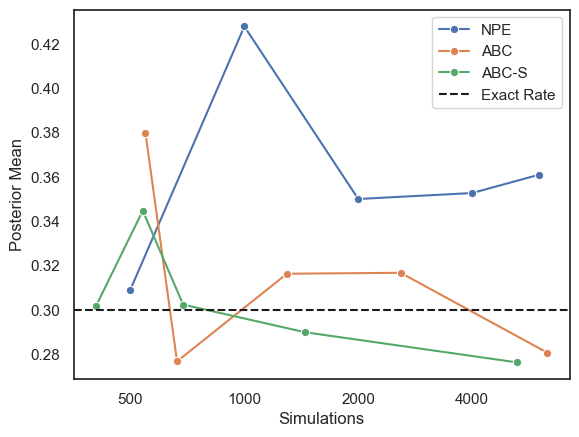

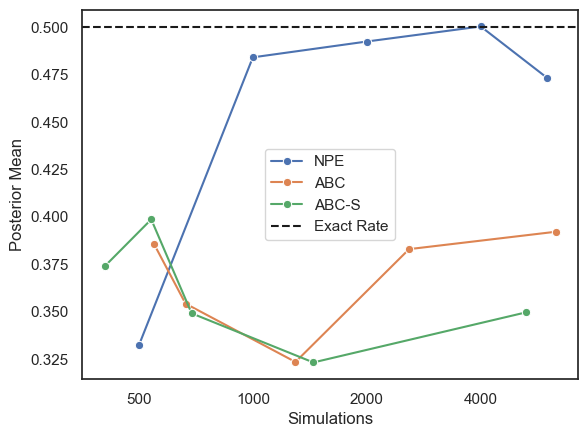

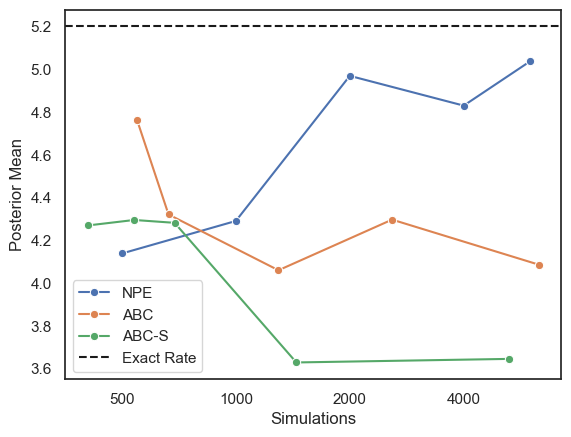

In [22]:
# for i in range(7):
#     het_plotter(i, "posterior mean")

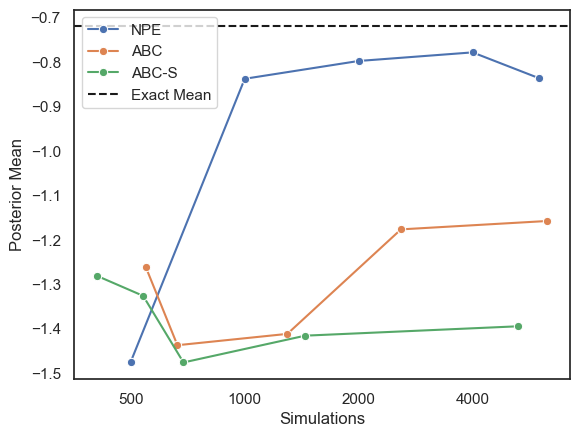

In [48]:
het_plotter(5, "mean", savename="images/het_bias.png")

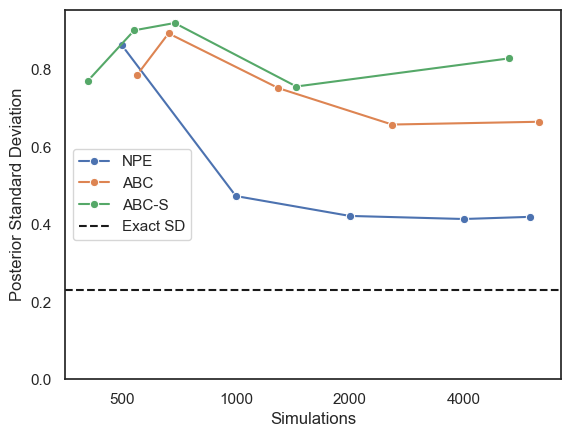

In [49]:
het_plotter(5, "sd", savename="images/het_variance.png")

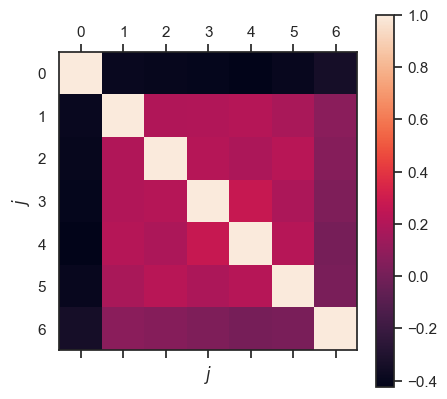

In [46]:
D = np.diag(1 / np.sqrt(np.diag(sigma)))
corr = D @ sigma @ D
plt.matshow(corr, cmap="rocket")
plt.colorbar()
plt.xlabel(r"$j$")
plt.ylabel(r"$j$")
plt.savefig("images/corr.png")
plt.show()

In [ ]:
# facility transmission rate is negatively correlated with everything else
# floor rates are positively correlated
# room rate is essentially uncorrelated with floor rates

## Model Identifiability

In [120]:
df_ident = pd.read_csv("model_id.csv")

In [140]:
mu = eval(df_ident["mu"].values[0])[0]
mu

[-1.938796043395996,
 -3.7973315715789795,
 -3.7603161334991455,
 -3.855451822280884,
 -3.994882106781006,
 -3.681385040283203,
 -3.812326431274414]

In [143]:
sigma = eval(df_ident["sigma"].values[0])
sds = [sigma[i][i]**0.5 for i in range(7)]
sds

[0.1745372409868084,
 1.1287694933993946,
 1.02779404667416,
 1.073197423749427,
 1.2043219718087481,
 0.9906793982554944,
 0.9539578660501598]

In [142]:
rates = [np.exp(mu[i] + sds[i]**2/2) for i in range(7)]
rates

[0.1460853236882722,
 0.042414233091054875,
 0.03947310076648944,
 0.037644234631112175,
 0.03801834772592109,
 0.0411446157365095,
 0.034828870426709554]

## Partial Observation

In [41]:
df_partial= pd.read_csv("partial_obs.csv")

In [43]:
mu = eval(df_partial["mu"].values[0])[0]
mu

[-3.035902976989746,
 -2.1406426429748535,
 -2.3056588172912598,
 -0.8645855784416199,
 -0.8369656801223755,
 -1.3076248168945312,
 1.0073436498641968]

In [44]:
sigma = eval(df_partial["sigma"].values[0])
sds = [sigma[i][i]**0.5 for i in range(7)]
sds

[0.42388049035100933,
 0.7070024811176431,
 0.8184705854430779,
 0.5568566957027872,
 0.5051096364257015,
 0.5725149191032712,
 1.0037638641198037]

In [45]:
rates = [np.exp(mu[i] + sds[i]**2/2) for i in range(7)]
rates

[0.05254603471187442,
 0.15096362143800965,
 0.13935763064991408,
 0.4918699687068738,
 0.4919403509642263,
 0.31862572190605154,
 4.531779089213824]